In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
import pandas as pd
import torch
import numpy as np
import random
import re
import spacy
import shutil
import matplotlib.pyplot as plt
!pip install transformers
!pip install bertviz
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertTokenizer, AutoModel, BertModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
import time
from scipy.stats import spearmanr
import h5py
import ast
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -O Stsbenchmark.tar.gz http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
shutil.unpack_archive('./Stsbenchmark.tar.gz', extract_dir='./', format='gztar')

--2024-01-26 03:12:42--  http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.es (ixa2.si.ehu.es)... 158.227.106.100
Connecting to ixa2.si.ehu.es (ixa2.si.ehu.es)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz [following]
--2024-01-26 03:12:42--  http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.eus (ixa2.si.ehu.eus)... 158.227.106.100
Connecting to ixa2.si.ehu.eus (ixa2.si.ehu.eus)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409630 (400K) [application/x-gzip]
Saving to: ‘Stsbenchmark.tar.gz’

Stsbenchmark.tar.gz 100%[===================>] 400.03K   342KB/s    in 1.2s    

2024-01-26 03:12:44 (342 KB/s) - ‘Stsbenchmark.tar.gz’ saved [409630/409630]



In [5]:
def getSTSBenchmarkSents(filename='sts-train.csv', root='stsbenchmark/', encoding='utf-8'):
  f = open(root+filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for line in f:
    example = re.split(r'\t+', line)
    if len(example) > 7:
      example = example[:-2]
    s2.append(example[-1])
    s1.append(example[-2])
    target.append(float(example[-3]))
  print("{} samples: {}".format(filename, len(target)))
  return s1, s2, target

In [6]:
s1_train,s2_train,target_train = getSTSBenchmarkSents(filename='sts-train.csv')

sts-train.csv samples: 5749


In [7]:
s1_test,s2_test,target_test= getSTSBenchmarkSents(filename='sts-test.csv')

sts-test.csv samples: 1379


In [8]:
s1_dev,s2_dev,target_dev= getSTSBenchmarkSents(filename='sts-dev.csv')

sts-dev.csv samples: 1500


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
CORPUS = 'STS-B'
BERT_PATH = "bert-base-uncased"
root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'

In [11]:
TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
def encode_sents(sents1, sents2):
    input_ids_ = []
    attention_masks_ = []
    type_ids_ = []
    for i, sent1 in enumerate(sents1):
        encoded_dict = TOKENIZER.encode_plus(
                            sent1,                      # Sentence 1 to encode.
                            sents2[i],                  # Sentence 2 to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = MAX_LEN,       # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

        # Add the encoded sentence to the list.
        input_ids_.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_.append(encoded_dict['attention_mask'])

        type_ids_.append(encoded_dict['token_type_ids'])
    return input_ids_, attention_masks_, type_ids_

In [13]:
def getEncodedTensors(s1, s2, labels):
    input_ids, attention_masks, type_ids = encode_sents(s1, s2)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, type_ids, labels

In [14]:
input_ids_train,attention_masks_train,type_ids_train,labels_train = getEncodedTensors(s1_train,s2_train,target_train)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval = getEncodedTensors(s1_dev, s2_dev, target_dev)

In [16]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, type_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_eval, attention_masks_eval, type_ids_eval, labels_eval)

In [17]:
# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order.
torch.manual_seed(42)
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
            #num_workers=2
        )
torch.manual_seed(42)
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
            #num_workers=2
        )

In [18]:
# See first batch
#batch = next(iter(train_loader))
#print(batch[0]) # 0 -> input_ids , 1 -> attention_masks, 2 -> type_ids, 3 -> targets
#print(train_loader.batch_size) #tamaño del batch
print('Number of train batches: {}'.format(len(train_loader)))# número de batches
print('Number of evaluation batches: {}'.format(len(val_loader)))

Number of train batches: 180
Number of evaluation batches: 47


In [21]:
class BertBaseUncasedRegressor(nn.Module):
  def __init__(self, num_classes = 1, dropout=0.1, has_attentions=True, has_hidden_states = True, n_layers = 0):
      super().__init__()
      self.bert = BertModel.from_pretrained(BERT_PATH, output_attentions=has_attentions, output_hidden_states = has_hidden_states) #load the model
      # Return:
      # last_hidden_state.shape -> [batch_size, num_tokens_in_sequence,hidden_size] (bert_base hidden_size = 768)
      # pooler_output.shape -> [batch_size, hidden_size] se utiliza una capa de pooling simple que aplica una transformación
      # lineal seguida de una función de activación tangente hiperbólica (tanh) a la última representación oculta (last_hidden_state) del token [CLS].
      layers = []
      for _ in range(n_layers):
          layers.append(nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)) #self.bert.config.hidden_size -> nos da el tamaño oculto
          layers.append(nn.Dropout(dropout))
      layers.append(nn.Linear(self.bert.config.hidden_size, num_classes)) #self.bert.config.hidden_size -> nos da el tamaño oculto

      self.regressor = nn.Sequential(*layers)


  def forward(self, input_ids, type_ids, mask, layer_index_HS=12):
      bert_output =self.bert(input_ids=input_ids, token_type_ids = type_ids, attention_mask= mask)

      #output = bert_output.pooler_output
      if type(layer_index_HS) == str:
        output = bert_output.last_hidden_state[:, 0, :] # CLS token
      else:
        output = bert_output.hidden_states[layer_index_HS][:, 0, :]
      logits = self.regressor(output)
      #logits = self.regressor(output_drop)
      return logits, bert_output

In [20]:
model = BertBaseUncasedRegressor(n_layers = 2, dropout=0.132).to(device)
#model = BertBaseUncasedRegressor(n_layers = 2, dropout=0.0152).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [37]:
criterion = nn.MSELoss()
LEARNING_RATE = 2.45e-05 #3.36e-5
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [38]:
def pearson_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)
    return np.corrcoef(all_preds, all_targets)[0, 1]

In [39]:
def spearman_corr(y_pred, y_true):
    all_preds = np.concatenate(y_pred)
    all_targets = np.concatenate(y_true)

    corr, _ = spearmanr(all_preds, all_targets)
    return corr

In [40]:
def train_loop(model,loader,optimizer,criterion,device,layer_idx ='last_hidden_state',clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    all_preds = []
    all_targets = []
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    for i, batch in enumerate(loader):

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        optimizer.zero_grad()
        #Forward
        outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
        outputs = outputs.squeeze(-1)
        #Loss
        loss = criterion(outputs.view(-1), labels.float())
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        loss_sum += loss.item()

        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(labels.float().detach().cpu().numpy())

    epoch_train_loss = loss_sum / len(loader)
    epoch_train_pearson = pearson_corr(all_preds, all_targets)
    epoch_train_spearman = spearman_corr(all_preds, all_targets)

    return epoch_train_loss, epoch_train_pearson, epoch_train_spearman


In [41]:
def evaluation_loop(model,loader,criterion,device,layer_idx ='last_hidden_state'):
    #Evaluation loop
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        all_preds = []
        all_targets = []

        for i, batch in enumerate(loader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            #Forward
            outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask, layer_index_HS=layer_idx)
            outputs = outputs.squeeze(-1)
            #Loss
            loss = criterion(outputs.view(-1), labels.float())

            loss_sum += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.float().detach().cpu().numpy())

        epoch_dev_loss = loss_sum / len(loader)
        epoch_dev_pearson = pearson_corr(all_preds, all_targets)
        epoch_dev_spearman = spearman_corr(all_preds, all_targets)

    return epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman

In [42]:
NUM_EPOCHS = 5
root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'
best_valid_loss = float('inf')
MODEL_FILE_NAME = CORPUS+'_'+BERT_PATH+'_'+str(MAX_LEN)+'_tunned_model.pt'
history = {"train": {"loss": [],"pearson": [],'spearman':[]}, "val": {"loss": [],"pearson": [],'spearman':[]}}
layer_HS_idx = 12 # from 1 to 12 in the base model
torch.cuda.empty_cache()

seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.set_device(0)

for epoch in range(NUM_EPOCHS):

    start_time = time.time()

    epoch_train_loss, epoch_train_pearson, epoch_train_spearman = train_loop(model,train_loader,optimizer,criterion,device,layer_HS_idx)
    epoch_dev_loss, epoch_dev_pearson, epoch_dev_spearman = evaluation_loop(model,val_loader,criterion,device,layer_HS_idx)

    elapsed_time = time.time() - start_time

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model.state_dict(), root_drive + MODEL_FILE_NAME)


    history["train"]["loss"].append(round(epoch_train_loss,4))
    history["val"]["loss"].append(round(epoch_dev_loss,4))
    history["train"]["pearson"].append(round(epoch_train_pearson,4))
    history["val"]["pearson"].append(round(epoch_dev_pearson,4))
    history["train"]["spearman"].append(round(epoch_train_spearman,4))
    history["val"]["spearman"].append(round(epoch_dev_spearman,4))

    print('-' * 80)
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Time: {elapsed_time:.4f}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print(f'Train Pearson Coef: {epoch_train_pearson:.4f} | Dev Pearson Coef: {epoch_dev_pearson:.4f}')
    print(f'Train Spearman Coef: {epoch_train_spearman:.4f} | Dev Spearman Coef: {epoch_dev_spearman:.4f}')

--------------------------------------------------------------------------------
Epoch: 001/5 | Time: 114.9766s | Train loss: 0.1666 | Dev loss: 0.4563
Train Pearson Coef: 0.9611 | Dev Pearson Coef: 0.8972
Train Spearman Coef: 0.9564 | Dev Spearman Coef: 0.8932
--------------------------------------------------------------------------------
Epoch: 002/5 | Time: 116.2401s | Train loss: 0.1202 | Dev loss: 0.4372
Train Pearson Coef: 0.9718 | Dev Pearson Coef: 0.8980
Train Spearman Coef: 0.9668 | Dev Spearman Coef: 0.8943
--------------------------------------------------------------------------------
Epoch: 003/5 | Time: 116.9783s | Train loss: 0.0609 | Dev loss: 0.5891
Train Pearson Coef: 0.9858 | Dev Pearson Coef: 0.8973
Train Spearman Coef: 0.9830 | Dev Spearman Coef: 0.8927
--------------------------------------------------------------------------------
Epoch: 004/5 | Time: 116.8036s | Train loss: 0.0612 | Dev loss: 0.4512
Train Pearson Coef: 0.9857 | Dev Pearson Coef: 0.8978
Train Sp

TEST

In [43]:
model.load_state_dict(torch.load(root_drive + MODEL_FILE_NAME, map_location=torch.device(device)))
layer_HS_idx = 12
input_ids_test, attention_masks_test, type_ids_test, labels_test = getEncodedTensors(s1_test, s2_test, target_test)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, type_ids_test, labels_test)

torch.manual_seed(42)
test_iterator = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = BATCH_SIZE # Evaluate with this batch size.
                #num_workers=2
                )

test_loss, test_pearson, test_spearman = evaluation_loop(model,test_iterator,criterion,device,layer_HS_idx)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Pearson: {test_pearson:.3f}')
print(f'Test Spearman: {test_spearman:.3f}')

Test Loss: 0.602
Test Pearson: 0.859
Test Spearman: 0.849


In [44]:
test = list(zip(s1_test,s2_test,target_test))

In [45]:
def similarity_test(test_dataset, num_example, model, device, layer_idx):

    sents1, sents2, targets = zip(*test_dataset)
    print("Sent 1: ", sents1[num_example])
    print("Sent 2: ", sents2[num_example])
    encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[num_example]], [sents2[num_example]])

    input_ids_test = torch.cat(encode_inputs, dim=0)
    attention_masks_test = torch.cat(encode_att_mask, dim=0)
    type_ids_test = torch.cat(encode_type, dim=0)
    labels_test = torch.tensor(targets[num_example])

    #ejecución de encoder con oración origen y máscara origen
    with torch.no_grad():
        output, bert = model(input_ids=input_ids_test.to(device),type_ids=type_ids_test.to(device),mask=attention_masks_test.to(device),layer_index_HS=layer_idx)
        output =output.squeeze(1)

    print("Predicted Class: ", round(output.item(),3))
    print("Target Class: ", round(labels_test.item(),3))
    return sents1[num_example], sents2[num_example], bert, input_ids_test


In [46]:
def trim_attention(att, input_ids):
    # Get the length of the input sequence without padding
    input_len = np.count_nonzero(input_ids != 0)

    # Trim the attention to remove padding
    att_trimmed = att[:input_len, :input_len]

    # Normalize the attention so that rows sum to 1
    att_trimmed = att_trimmed / att_trimmed.sum(axis=-1, keepdims=True)

    return att_trimmed, input_len

In [47]:
def view_attention(bert, input_ids, attention_layer):
    """
    When a word is not in the vocabulary, the BERT tokenizer breaks it down into
    smaller subwords and adds the "#" prefix to each subword to indicate that it is part of the
    same original word. For example, the word "running" could be divided into "run" and "##ning".
    """
    # Get attention weights (batch_size, num_heads, sequence_length, sequence_length)
    batch_idx = 0  # always 0 for testing a sequence
    num_head = 0
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axs.flat):
        attention = bert.attentions[attention_layer][batch_idx][i].cpu().detach().numpy()
        # Trim the attention matrix
        att_trimmed, sent_dim = trim_attention(attention, input_ids)
        sent = TOKENIZER.convert_ids_to_tokens(input_ids.squeeze().tolist())[:sent_dim]
        # Visualize the trimmed attention matrix
        ax.matshow(att_trimmed, cmap='viridis')
        ax.set_title('Head ' + str(i + 1))
        # axs[0].matshow(att_trimmed, cmap='hot')
        ax.set_xticks(np.arange(len(sent)), sent, rotation=90)
        ax.set_yticks(np.arange(len(sent)), sent)
        # plt.title('BERT model attention for two sentences')
    plt.tight_layout()
    plt.show()

In [48]:
def save_attentions(test_dataset, model, device, layer_idx = 12):
    sents1, sents2, targets = zip(*test_dataset)
    all_attentions = {}
    dimensions = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      # Execute encoder with source sentence and source mask
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Trim the attention matrix
              att_trimmed, sent_dim = trim_attention(attention, input_ids)
              all_attentions[(i,attention_layer,head)] = {'vectors' : att_trimmed, 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
              dimensions[i] = sent_dim
    return all_attentions

In [49]:
def save_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    hidden_states_outputs = {}
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      # Execute encoder with source sentence and source mask
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            hidden_states_outputs[(i,layer)] = {'hidden_state' : hidden_state, 'label' : targets[i]} #all outputs have (1,128,768)
    return hidden_states_outputs

In [50]:
def save_CLS_outputs(test_dataset, model, device, layer_idx = 12): #save encoder outputs
    sents1, sents2, targets = zip(*test_dataset)
    CLS_outputs_vectors, CLS_outputs = {}, {}
    sent_dim = 0
    for i in range(len(test_dataset)):
      encode_inputs, encode_att_mask, encode_type = encode_sents([sents1[i]], [sents2[i]])
      input_ids = torch.cat(encode_inputs, dim=0)
      attention_masks = torch.cat(encode_att_mask, dim=0)
      type_ids = torch.cat(encode_type, dim=0)
      labels = torch.tensor(targets[i])

      # Execute encoder with source sentence and source mask
      with torch.no_grad():
          output, bert = model(input_ids=input_ids.to(device),type_ids=type_ids.to(device),mask=attention_masks.to(device),layer_index_HS=layer_idx)
          output =output.squeeze(1)

      for attention_layer in range(12):
          for head in range(12):
              attention = bert.attentions[attention_layer][0][head].cpu().detach().numpy()
              # Trim the attention matrix
              att_trimmed, sent_dim = trim_attention(attention, input_ids)

      for layer, hidden_state in enumerate(bert.hidden_states):
          if layer > 0 : #the first layer is embedding
            CLS_outputs_vectors[(i,layer-1)] = {'vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
            #CLS_outputs[(i,layer-1)] = {'CLS_vectors' : hidden_state[:, 0, :], 'sequence': 's1: ' + sents1[i] + ' s2: ' + sents2[i].replace("\n", ""), 'label' : targets[i], 'dimension' : sent_dim}
    return CLS_outputs_vectors

In [ ]:
CLS_outputs_vectors = save_CLS_outputs(test, model, device)

In [ ]:
hidden_states_outputs = save_outputs(test, model, device)

In [51]:
all_attentions = save_attentions(test, model, device)

In [52]:
all_attentions[(0,6,5)]

{'vectors': array([[1.50586097e-02, 3.61832295e-04, 2.97799357e-04, 5.38227148e-04,
         2.56233593e-03, 4.05949249e-04, 5.69995551e-04, 9.65356769e-04,
         1.41209349e-01, 4.38355505e-02, 5.73635288e-02, 1.09668888e-01,
         2.51616776e-01, 1.47769123e-01, 5.88519461e-02, 3.06893922e-02,
         1.38235271e-01],
        [1.52388157e-03, 5.30413410e-04, 1.34817898e-01, 3.50452662e-02,
         4.19157557e-03, 7.32167275e-04, 3.51839885e-03, 1.76969019e-03,
         4.22646403e-01, 2.23457228e-05, 1.76440377e-03, 5.74794307e-04,
         6.09808718e-04, 3.24637294e-05, 1.15516486e-04, 4.79139890e-05,
         3.92057061e-01],
        [7.08082298e-05, 1.64573154e-04, 2.20526615e-03, 1.34855346e-03,
         7.60508468e-03, 3.84600629e-04, 5.59357693e-03, 8.18138360e-05,
         5.17271519e-01, 1.74146430e-06, 7.35187768e-06, 5.03655747e-06,
         2.33623170e-04, 3.45294029e-06, 4.33451714e-05, 1.53082931e-06,
         4.64978188e-01],
        [1.63988105e-03, 5.87702310

In [53]:
def save_with_hdf5(file_path, data_dict):
    # Save data in HDF5 format
    with h5py.File(file_path, 'w') as hf:
        # Iterate through the dictionary and save the data to the HDF5 file
        def save_dict(group, data):
            for key, value in data.items():
                key_str = str(key)  # Convert the key to a string
                if isinstance(value, dict):
                    # If the value is a dictionary, create a new group and save the data inside it
                    subgroup = group.create_group(key_str)
                    save_dict(subgroup, value)
                elif isinstance(value, np.ndarray):
                    # If the value is a NumPy array, save it as a dataset
                    group.create_dataset(key_str, data=value)
                else:
                    # For other data types, save them as attributes
                    group.attrs[key_str] = str(value)  # Convert the value to a string and save it as an attribute

        save_dict(hf, data_dict)

In [ ]:
"""
#Toy example
example = {
    (0,1) : {
        'vectors': np.array([[1, 2, 3], [4, 5, 6]]),
        'sequence': 's1...',
    },
    (0,2) : {
        'vectors': np.array([[2, 2, 2], [3, 3, 3]]),
        'sequence': 's2...',
    }
}

save_with_hdf5('example.h5', example)
"""

In [54]:
file_name = 'embeddings_att_sts_b.h5'

In [55]:
save_with_hdf5(file_name, all_attentions)

In [56]:
def is_tuple(string):
    try:
        result = ast.literal_eval(string)
        return isinstance(result, tuple)
    except (SyntaxError, ValueError):
        return False

In [57]:
def load_with_hdf5(file_path):
    loaded_data = {}

    # Load data from the HDF5 file
    with h5py.File(file_path, 'r') as hf:
        # Recursive function to load data from the HDF5 file
        def load_dict(group):
            result = {}
            for key, item in group.items():
                # Use the key directly if it is a string, otherwise, convert back to tuple
                key_obj = ast.literal_eval(key) if is_tuple(key) else key
                if isinstance(item, h5py.Group):
                    # If it's a group, load its data recursively
                    result[key_obj] = load_dict(item)
                    # Retrieve attributes from the group
                    for attr_key, attr_value in item.attrs.items():
                        result[key_obj][attr_key] = attr_value
                else:
                    # If it's a dataset, load its values
                    result[key_obj] = torch.tensor(np.array(item))
            return result

        loaded_data = load_dict(hf)

    return loaded_data

In [58]:
# Load data
loaded_data_embeddings = load_with_hdf5(file_name)

In [59]:
loaded_dict = loaded_data_embeddings

In [64]:
loaded_dict[(100,6,5)]

{'vectors': tensor([[1.6196e-03, 2.7198e-04, 2.7493e-04, 3.4435e-04, 7.1982e-04, 1.3362e-03,
          1.9165e-04, 2.2783e-04, 2.3817e-04, 4.7490e-01, 7.0693e-03, 2.4012e-02,
          1.3970e-02, 1.5914e-02, 4.2691e-03, 2.0217e-03, 4.5262e-01],
         [2.9286e-04, 6.4306e-04, 4.6194e-01, 2.4523e-02, 1.6265e-01, 2.0754e-02,
          1.7591e-04, 5.8353e-03, 1.1483e-03, 1.6391e-01, 1.3203e-05, 2.8889e-03,
          4.8692e-04, 4.6128e-04, 1.8538e-03, 6.6142e-05, 1.5236e-01],
         [2.2125e-04, 7.8481e-04, 6.4532e-03, 8.0052e-03, 3.1463e-02, 8.5297e-03,
          2.5495e-04, 1.1069e-03, 8.8157e-04, 4.9307e-01, 7.6001e-06, 1.6685e-05,
          4.6035e-05, 2.0861e-04, 7.9519e-05, 2.1833e-05, 4.4885e-01],
         [1.1315e-03, 9.7504e-03, 2.0254e-01, 1.2680e-02, 4.6729e-01, 1.4496e-01,
          8.7558e-03, 2.5535e-02, 1.0358e-02, 5.9003e-02, 5.5017e-05, 1.0173e-04,
          1.1557e-04, 2.1910e-03, 6.2860e-04, 1.1426e-04, 5.4785e-02],
         [7.2407e-04, 8.2247e-04, 1.0882e-02, 2.1

In [66]:
loaded_dict[(0,6,5)] #[(example_number, layer, head)]

{'vectors': tensor([[1.5059e-02, 3.6183e-04, 2.9780e-04, 5.3823e-04, 2.5623e-03, 4.0595e-04,
          5.7000e-04, 9.6536e-04, 1.4121e-01, 4.3836e-02, 5.7364e-02, 1.0967e-01,
          2.5162e-01, 1.4777e-01, 5.8852e-02, 3.0689e-02, 1.3824e-01],
         [1.5239e-03, 5.3041e-04, 1.3482e-01, 3.5045e-02, 4.1916e-03, 7.3217e-04,
          3.5184e-03, 1.7697e-03, 4.2265e-01, 2.2346e-05, 1.7644e-03, 5.7479e-04,
          6.0981e-04, 3.2464e-05, 1.1552e-04, 4.7914e-05, 3.9206e-01],
         [7.0808e-05, 1.6457e-04, 2.2053e-03, 1.3486e-03, 7.6051e-03, 3.8460e-04,
          5.5936e-03, 8.1814e-05, 5.1727e-01, 1.7415e-06, 7.3519e-06, 5.0366e-06,
          2.3362e-04, 3.4529e-06, 4.3345e-05, 1.5308e-06, 4.6498e-01],
         [1.6399e-03, 5.8770e-03, 4.0331e-02, 2.7032e-02, 2.3597e-01, 1.4637e-02,
          8.7776e-02, 7.1694e-03, 2.9967e-01, 1.1004e-04, 2.0251e-04, 1.5079e-04,
          2.9831e-03, 7.9836e-05, 2.6768e-04, 7.9469e-05, 2.7602e-01],
         [6.0715e-05, 1.5028e-05, 1.3069e-04, 1.4

In [72]:
example = 621
s1, s2, bert, inputs = similarity_test(test, example, model, device, 12)

Sent 1:  The dog is chasing the geese.
Sent 2:  One dog is chasing the other.

Predicted Class:  2.772
Target Class:  1.6


In [69]:
path = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base'

In [70]:
#!mv file_name path
!cp {file_name} {path}

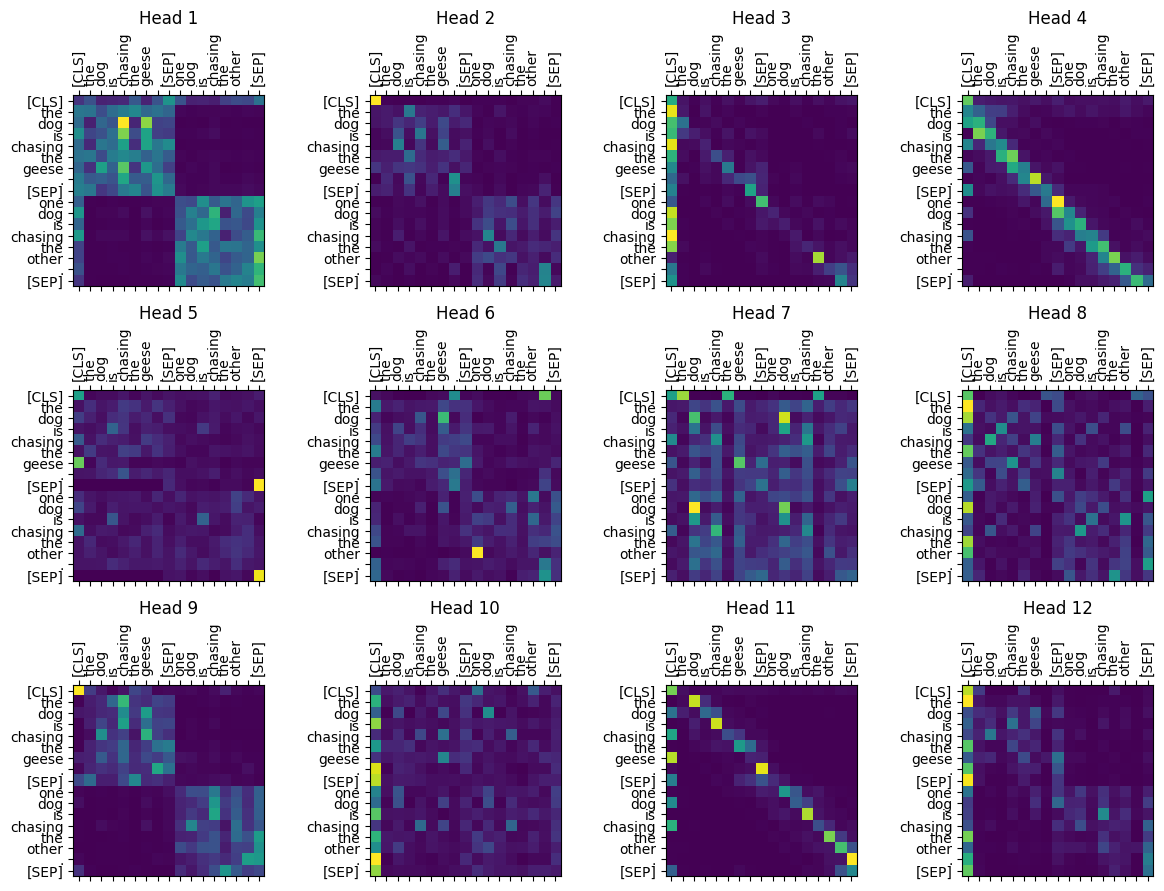

In [73]:
view_attention(bert, inputs, 0) # (bert, example_inputs, layer)